# Dissertation Explanation and Exploration

This Notebook contains figures used in my dissertaition. Some to explain concepts and some to demonstrate my project

In [2]:
from Antenna import Antenna
from Array import Array
from Model import Model

import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Vector 'closeness' explanation

This section contains the ideas and methods behind the core of the AOA algorithm

Before, we were inferring by antenna-pairs, comparing the difference of each antenna with another. For clarity's sake we refer to the middle antenna in the array as `AM`, the antenna in the +ve theta direction to that (counter-clockwise) is refered to as `AL (Antenna Left)`, because when the array is pointing towards theta = 0, that antenna is to the left. Likewise, the antenna in the clockwise (negative theta) direction, is refered to `AR (Antenna Right)`. If we were to take the gain of all the antenna in the array in the range $\theta=\{0,2\pi\}$, we would get the following gain pattern:

c:\Users\euan\OneDrive\Desktop\Dissertation Project\Angle Probability\Antenna.py:115: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(side_lobes,lobes_dB,190,rcond=0)
c:\Users\euan\OneDrive\Desktop\Dissertation Project\Angle Probability\Antenna.py:115: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(side_lobes,lobes_dB,190,rcond=0)
c:\Users\euan\OneDrive\Desktop\Dissertation Project\Angle Probability\Antenna.py:115: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(side_lobes,lobes_dB,190,rcond=0)


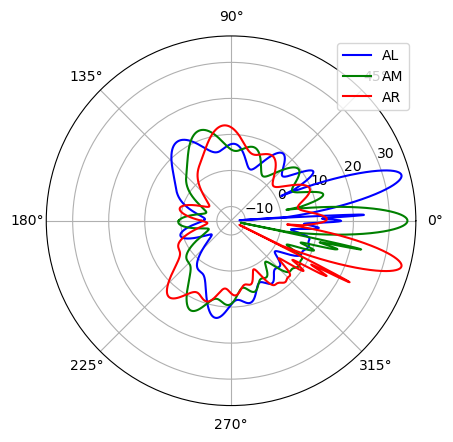

In [3]:
m = Model(np.pi/20,100,np.pi/12)
m.polar_plot(legend=True)

For the simplicity of explaining how the algorithm works, we will just consider the antennas AL and AM, and for further simplicity we will consider only the main lobe of the antenna which is given by the equation $r=gain_{amp}+gain_{base}*\cos(\theta)^a$, seen here

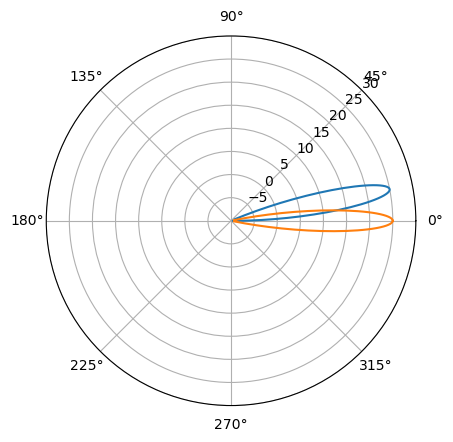

In [4]:
theta = np.linspace(0,2*np.pi,1000)
AL = m.array.ant_left.main_lobe_approx_narrow(theta-np.pi/16)
AM = m.array.ant_middle.main_lobe_approx_narrow(theta)

fig = plt.figure()
ax = plt.subplot(projection="polar")

ax.set_rlabel_position(45)
ax.set_rlim(-10,30)
ax.plot(theta, AL)
ax.plot(theta, AM)

As you can probably tell, this is a massive over-simplification of how the antennas' gains look like in real life, but it helps illustrate a point. There is an obvious beam where these antenna are pointing, this is where the antenna are essentially effective. There is a relationship between the two patterns, for example if a sample gives AL = 25 and AM = 0, we know the sample must be taken somewhere in the +ve $\theta$ direction. 

The gain is something we can measure really easily. The gain of one antenna on it's own doesn't tell us much, but the gain of two antenna relative to each other give us a lot more information. Theoretically the angle of where a sample is taken is encoded within the recorded strengths of the antenna.

Because we are measuring in dB, the relative strengths of the antenna compared to each other will always be the same, i.e. the attenuation (signal lost) will be the same across each antenna, no matter how far away you are. $observed=true-a$, where a is attenuation. This doesn't take into account noise yet, we will come to that later.

In other words, the true gain (t) is only determined by the direction (angle) from the antenna. Graphs of true gain are shown above. The observed gain (s) is determined by the true gain minus attenuation.

Therefore
$$
    P(S|\theta,a) \sim N(\begin{bmatrix} s_1 \\ s_2 \\ s_3 \end{bmatrix}|\begin{bmatrix} t_1-a \\ t_2-a \\ t_3-a \end{bmatrix},b)
$$

Where $b$ is some independant noise, assumed to be gaussian.

We want to find: $p(\theta|s_1,s_2,s_3)$

So using bayes rule:

$$
    p(\theta|s_1,s_2,s_3) = \frac{p(s_1,s_2,s_3|\theta)p(\theta)}{p(s_1,s_2,s_3)}
$$

$p(\theta)$ is flat, as all angles are equally as likely as each other.

The likelihood $p(s_1,s_2,s_3|\theta)$ can be related back to above to attenuation x2. Meaning that it can be calculated numerically using an itergral:

$$
    p(S|\theta) = \int{}{} p(S|\theta, a)p(a) \, da
$$

As we noticed earlier $p(a)$ is uniform over $\R$, meaning it vanishes due to it being an improper prior.

Keep this in mind as I now explain something that is decently hard to get your head around.

Taking just our 2 antenna AL, AM, we can plot their strengths against each other, i.e. when AL is at x AM is at a,b,c,d..., and this gives us this function:

Text(0, 0.5, 'Gain AM (db)')

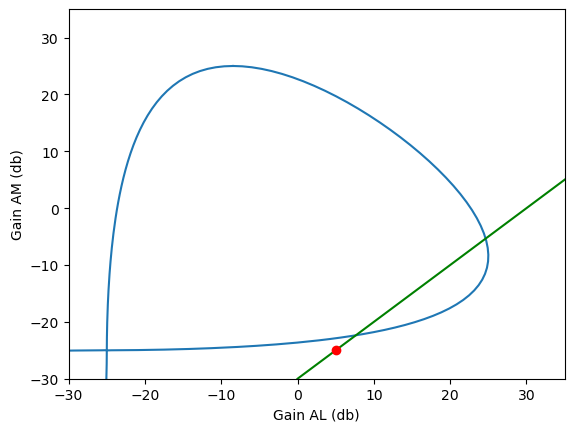

In [27]:
fig = plt.figure()
ax = plt.subplot()

ax.plot(AL, AM)
ax.plot([0,40],[-30,10], 'g')
ax.plot(5,-25,'or')
ax.set_ylim(-30,35)
ax.set_xlim(-30,35)
ax.set_xlabel("Gain AL (db)")
ax.set_ylabel("Gain AM (db)")



So how does this help us? Well considering that attenuation will stay constant for each antenna no matter the distance, this function will hold true no matter the distance (until we start to lose packets), the only thing that changes is that this function will be moved along the vector $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$ for our 2-antenna setup.

Therefore, given a noiseless sample, we can plot the sample then move in the $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$ direction until we intersect with the "true gain" graph above, and this will be our angle actual angle. Obviously we could intersect with multiple points of the function due to symmetry.

The red dot repersents a sample, the green line is the vector that passes in the direction $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$. This sample gives 2 possible 'true' gain pairs.

With the addition of noise, it would be more helpful to think of the true values as the same function as before, but with with a gaussian error in each direction.

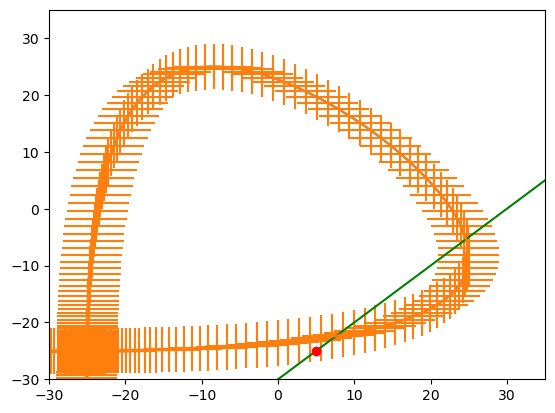

In [28]:
fig = plt.figure()
ax = plt.subplot()
ax.set_ylim(-30,35)
ax.set_xlim(-30,35)
ax.plot(AL, AM)

ax.errorbar(AL,AM,4,4)
ax.plot([0,40],[-30,10], 'g')
ax.plot(5,-25,'or')

This graph shows the same function but with error bars at $\pm4$ in both antenna, representing the 1st standard deviation of the model. You can now see that a recorded sample comtains a lot more error in it's projection. There is now a distribution of angles the red sample leads to if you take it back to the true gain graph.

This is where we can use the inference from earlier in a more intuitive way.

For each theta we get $t_1 = g_l(\theta), t_2 = g_r(\theta)$ as the true values. Then for each of these we compute the distance from $S$ to the vector that passes through $t_1, t_2$ in direction $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$. We then use this distance (d) to compute the univariate normal density:

$$
    N(d|0,b^2)
$$

To compute the normal distance we can do:
DISTANCE CALCULATIONS

If we do this over each angle, we get a likelihood for each angle. Then normalising over $\theta$ we get a probability density over all angles